# CS 171 / EE 142 Problem Set 4
# Due Sunday, December 6, 2020 @ 11:59pm 

## Read *all* cells carefully and answer all parts (both text and code)

### Enter your information below:

<div style="color: #000000;background-color: #FFCCCC">
    Your Name (submitter): <br>
Your student ID (submitter):
</div>

<div style="color: #000000;background-color: #FFCCFF">
    Total Grade: /30<br>
    Late Days on this assigment: <br>
    Total Late Days so far: <br>
    </div>

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part I: Association Rules</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 1:</font> <font size=+1>(4 points)</font>

If there are $n$ items (or features), there are $3^n-2^{n+1}+1$ different possible association rules.  Prove this.

You need a _clear_ explanation.  Note, associate rules must have a non-empty set on the left-hand and right-hand sides.
</div>

For a given rule, each item is either (1) on the left-hand side, (2) on the right-hand side, or (3) not in the rule.  This would give $3^n$ different rules.  However, $2^n$ of these rules have an empty left-hand side ($2^n$ is the number of rules whether each item is either on the right-hand side or not in the rule).  Similiarly, $2^n$ of these rules have an empty right-hand side.  However, $1$ rule has both (and thus would be double counted if we just added the number of right-hand-empty and left-hand-empty rules).  So the total is $3^n - 2^n - 2^n + 1 = 3^n - 2^{n+1} +1$.

<div style="color: #000000;background-color: #FFCCFF">
    Q1:<br>
    Grade: /4<br>
    </div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 2:</font> <font size=+1>(12 points)</font>
    
In this question, you will write code to do association rule learning, as described in class.

The items will be represented by numbers (for ease and speed) with a separate
list of the names for each item.  `loaddata` (below) loads in a dataset and returns these three things: a list of the names of each item, a list of the examples, and the total number of items.  Each example is a set of numbers representing.  For example, for the toy problem in lecture, loaddata returns

`['Jurassic Park', 'Star Wars', 'Forrest Gump', 'Home Alone', 'Toy Story']`

`[[1, 2, 4], [1, 4], [1, 3, 4], [0, 1], [0, 3], [1, 3, 4], [0, 2, 3], [3], [1, 3, 4], [1]]`

`5`

You should use `set`s and `frozenset`s (core python data structures) in your code.  You can read more about them at https://docs.python.org/3/library/stdtypes.html#set

Write the functions `learnrules` and `writerules`, plus any additional helper functions you need.  Use the apriori algorithm to generate "large item lists" and the algorithm from class to find rules that meet the minimum support and confidence given.
</div>

In [1]:
from itertools import combinations, chain #do not import anything else 
# (you may or may not use combinations -- up to you)

# prints out a set, nicely
# names is an optional list of the names for each of the (integer) items
def settostr(s,names=None):
    if names is None:
        elems = [str(e) for e in s]
    else:
        elems = [names[e] for e in s]
    return "{" + (", ".join(elems)) + "}"

In [2]:
# loads in data from filename, assuming the file format used for this assignment
def loaddata(filename):
    with open(filename) as f:
        nitems = int(f.readline())
        names = [f.readline().strip() for i in range(nitems)]
        nrows = int(f.readline())
        data = [[int(s) for s in f.readline().split()] for i in range(nrows)]
        f.close()
        return (names,data,nitems)        

In [3]:
def countindata(iset,data):  
    return sum(1 for d in data if iset.issubset(d))

def powerset(s, incempty = True, incall = True):
    return chain.from_iterable(combinations(s,r) for r in range(0 if incempty else 1, len(s)+1 if incall else len(s)))

def support(rule,data):
    return countindata(rule[0].union(rule[1]),data)/float(len(data))

def confidence(rule,data):
    return countindata(rule[0].union(rule[1]),data)/float(countindata(rule[0],data))

def apriorigen(Lprev,data,i):
    C = set()
    for (I,J) in combinations(Lprev,r=2):
        if len(I.intersection(J)) == i-2:
            C.add(I.union(J))
    return C
    
def apriori(nitems,data,minsupport):
    mincount = len(data)*minsupport
    currL = set([frozenset([i]) for i in range(nitems) if countindata(frozenset([i]),data)>=mincount])
    L = currL.copy() ## ??? shallow copy... is that okay?
    i = 1
    while len(currL)>0:
        
        i = i+1
        #print ("at level %d from %d at prev"%(i,len(currL)))
        currC = apriorigen(currL,data,i)
        currL = set()
        for c in currC:
            if countindata(c,data) >= mincount:
                currL.add(c)
        L = L.union(currL)
    return L

def learnrules(numitems,data,minsupport,minconfidence):
    ### ADD YOUR CODE HERE (of course, feel free to add other functions!)
    ### Should return a list of rules.  
    ### Each rule should be a pair of two sets (lhs and rhs)
    
    #print ("starting to learn")
    R = set()
    L = apriori(numitems,data,minsupport)
    for Z in L:
        numz = countindata(Z,data)
        for Xtup in powerset(Z,False,False):
            X = frozenset(Xtup)
            if numz/countindata(X,data) >= minconfidence:
                R.add((X,Z-X))
    return R
                
            

In [4]:
def writerule(rule,itemnames):
    return settostr(rule[0],itemnames) + " => " + settostr(rule[1],itemnames)

def writerules(rules,data,itemnames):
    ### ADD YOUR CODE HERE
    ## should print out each rule, *sorted by confidence*, (high to low) one per line
    ## each line should list the support, then the confidence, then the rule
    ## to line up the columns nicely, use
    ##       "{:7.4f}".format(x)
    ## to print the floating point number in the variable x
    ## use settostr (above) to write out the itemsets
    
    rs = [(confidence(r,data),r) for r in rules]
    rs.sort(key=lambda r : -r[0])
    for r in rs:
        print ("{:7.4f}".format(support(r[1],data)) + " " + "{:7.4f}".format(r[0]) + "    " + writerule(r[1],itemnames))
    

In [5]:
# prints the rule set
def printruleset(datasetfilename,minsupport,minconfidence):
    (itemnames,data,numitems) = loaddata(datasetfilename)
    rules = learnrules(numitems,data,minsupport,minconfidence)
    writerules(rules,data,itemnames)

In [6]:
## toy dataset example
printruleset('toymovies.txt',0.3,0.5)
''' output should look like
 0.5000  1.0000    {Toy Story} => {Star Wars}
 0.3000  1.0000    {Star Wars, Home Alone} => {Toy Story}
 0.3000  1.0000    {Home Alone, Toy Story} => {Star Wars}
 0.5000  0.7143    {Star Wars} => {Toy Story}
 0.3000  0.6000    {Star Wars, Toy Story} => {Home Alone}
 0.3000  0.6000    {Toy Story} => {Home Alone}
 0.3000  0.6000    {Toy Story} => {Star Wars, Home Alone}
 0.3000  0.5000    {Home Alone} => {Toy Story}
 0.3000  0.5000    {Home Alone} => {Star Wars, Toy Story}
 0.3000  0.5000    {Home Alone} => {Star Wars}
'''

 0.5000  1.0000    {Toy Story} => {Star Wars}
 0.3000  1.0000    {Star Wars, Home Alone} => {Toy Story}
 0.3000  1.0000    {Home Alone, Toy Story} => {Star Wars}
 0.5000  0.7143    {Star Wars} => {Toy Story}
 0.3000  0.6000    {Star Wars, Toy Story} => {Home Alone}
 0.3000  0.6000    {Toy Story} => {Home Alone}
 0.3000  0.6000    {Toy Story} => {Star Wars, Home Alone}
 0.3000  0.5000    {Home Alone} => {Toy Story}
 0.3000  0.5000    {Home Alone} => {Star Wars, Toy Story}
 0.3000  0.5000    {Home Alone} => {Star Wars}


' output should look like\n 0.5000  1.0000    {Toy Story} => {Star Wars}\n 0.3000  1.0000    {Star Wars, Home Alone} => {Toy Story}\n 0.3000  1.0000    {Home Alone, Toy Story} => {Star Wars}\n 0.5000  0.7143    {Star Wars} => {Toy Story}\n 0.3000  0.6000    {Star Wars, Toy Story} => {Home Alone}\n 0.3000  0.6000    {Toy Story} => {Home Alone}\n 0.3000  0.6000    {Toy Story} => {Star Wars, Home Alone}\n 0.3000  0.5000    {Home Alone} => {Toy Story}\n 0.3000  0.5000    {Home Alone} => {Star Wars, Toy Story}\n 0.3000  0.5000    {Home Alone} => {Star Wars}\n'

In [8]:
%%time
# the full groceries answer (should take under a minute to run)
printruleset('groceries.txt',0.01,0.5)

 0.0104  0.5862    {citrus fruit, root vegetables} => {other vegetables}
 0.0123  0.5845    {root vegetables, tropical fruit} => {other vegetables}
 0.0101  0.5824    {curd, yogurt} => {whole milk}
 0.0115  0.5736    {other vegetables, butter} => {whole milk}
 0.0120  0.5700    {root vegetables, tropical fruit} => {whole milk}
 0.0145  0.5630    {root vegetables, yogurt} => {whole milk}
 0.0123  0.5525    {domestic eggs, other vegetables} => {whole milk}
 0.0109  0.5245    {yogurt, whipped/sour cream} => {whole milk}
 0.0127  0.5230    {rolls/buns, root vegetables} => {whole milk}
 0.0135  0.5175    {pip fruit, other vegetables} => {whole milk}
 0.0151  0.5174    {tropical fruit, yogurt} => {whole milk}
 0.0223  0.5129    {other vegetables, yogurt} => {whole milk}
 0.0146  0.5070    {other vegetables, whipped/sour cream} => {whole milk}
 0.0122  0.5021    {rolls/buns, root vegetables} => {other vegetables}
 0.0129  0.5000    {root vegetables, yogurt} => {other vegetables}
CPU times: us

In [9]:
%%time
# a different groceries dataset, looking for rules with less support, but higher confidence (should take under a minute to run)
printruleset('groceries2.txt',0.001,0.7)

 0.0013  0.9231    {Other, Tartine} => {Coffee}
 0.0010  0.9091    {Medialuna, Hot chocolate, Other} => {Coffee}
 0.0015  0.8750    {Salad, Extra Salami or Feta} => {Coffee}
 0.0014  0.8667    {Toast, Pastry} => {Coffee}
 0.0013  0.8571    {Hearty & Seasonal, Sandwich} => {Coffee}
 0.0016  0.8333    {Other, Scone} => {Coffee}
 0.0010  0.8333    {Vegan mincepie, Cake} => {Coffee}
 0.0016  0.8333    {Salad, Sandwich} => {Coffee}
 0.0033  0.8158    {Extra Salami or Feta} => {Coffee}
 0.0054  0.8095    {Keeping It Local} => {Coffee}
 0.0016  0.7895    {Cookies, Scone} => {Coffee}
 0.0018  0.7727    {Juice, Pastry} => {Coffee}
 0.0010  0.7692    {Salad, Cake} => {Coffee}
 0.0014  0.7647    {Other, Extra Salami or Feta} => {Coffee}
 0.0028  0.7500    {Other, Toast} => {Coffee}
 0.0021  0.7407    {Other, Cookies} => {Coffee}
 0.0020  0.7308    {Juice, Spanish Brunch} => {Coffee}
 0.0016  0.7143    {Cake, Toast} => {Coffee}
 0.0010  0.7143    {Cake, Tea, Sandwich} => {Coffee}
 0.0235  0.7044  

<div style="color: #000000;background-color: #FFCCFF">
    Q2:<br>
    Grade: /12<br>
    </div>

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part II: Clustering</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 3:</font> <font size=+1>(4 points)</font>

The code below plots 6 points (in 2D feature space) and the associated dendrograms for
three types of linkage definitions: single, average, and complete.

However, for these six points, all three dendrograms are almost the same.  While the levels at which points are merged differ, the clusters generated are the same.

Change the points below (`pts`) so that each of the three linkages produces a different heirarchical clustering.
</div>

In [10]:
pts = [[1,0],[1,1.5],[2,1.5],[2,2],[2.75,2.1],[3,2.1]] ## Change only this line (but keep 6 points)
# pts = [[1,1],[1,2],[2,3],[2,4],[4,3],[5,3]] ## Change only this line (but keep 6 points) [orig]
pnames = ['A','B','C','D','E','F']

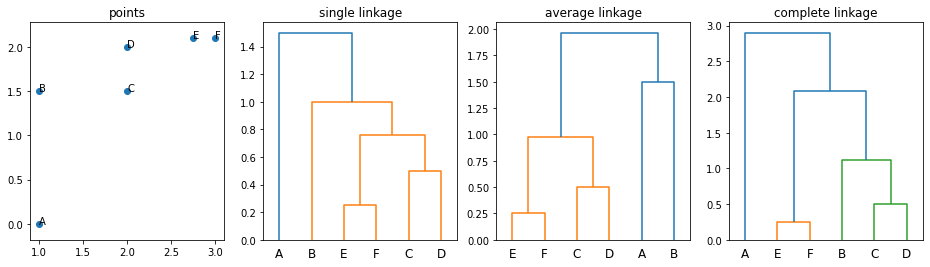

In [11]:
%matplotlib inline
from scipy.cluster import hierarchy
from scipy.spatial import distance
import matplotlib.pyplot as plt

ctypes = ['single','average','complete']

plt, axes = plt.subplots(1,len(ctypes)+1,figsize=(4+4*len(ctypes),4))

axes[0].scatter([x[0] for x in pts],[x[1] for x in pts])
for i,name in enumerate(pnames):
    axes[0].annotate(name,(pts[i][0],pts[i][1]))
axes[0].axis('equal')
axes[0].set_title('points')
    
for i,ctype in enumerate(ctypes):
    Z = hierarchy.linkage(distance.pdist(pts),ctype)
    hh = hierarchy.dendrogram(Z,ax=axes[i+1],labels=pnames)
    axes[i+1].set_title(ctype+ " linkage")

<div style="color: #000000;background-color: #FFCCFF">
    Q3:<br>
    Grade: /4<br>
    </div>